In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, ActivityRegularization
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
import matplotlib.mlab as mlab
import seaborn as sns
import time

Using TensorFlow backend.
/home/veruska/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/veruska/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/veruska/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/veruska/.local/lib/python3.6/site-packages/tensorflow/py

In [2]:
file_path = '../../data/input/integrated_data_dummy.csv'

data = pd.read_csv(file_path)
data = data.sort_values(["busCode","busCodeSB"])
data.head()

route  tripNum  shapeSequence  shapeLat   shapeLon  distanceTraveledShape  \
0     68        3          12580 -8.036231 -34.962342                 2505.0   
1     68        3          12581 -8.034150 -34.960756                 2794.0   
2     68        3          12582 -8.032878 -34.959775                 2971.0   
3     68        3          12583 -8.031478 -34.958622                 3171.0   
4     68        3          12585 -8.030508 -34.957567                 3392.0   

   busCode  gpsPointId    gpsLat     gpsLon  ...  alertTypeSB_ACCIDENT  \
0    12021         0.0 -8.036231 -34.962342  ...                     0   
1    12021       130.0 -8.034131 -34.960771  ...                     0   
2    12021         0.0 -8.032878 -34.959775  ...                     0   
3    12021       131.0 -8.030860 -34.958388  ...                     0   
4    12021       136.0 -8.030394 -34.957534  ...                     0   

   alertTypeSB_CHIT_CHAT  alertTypeSB_HAZARD  alertTypeSB_JAM  \
0                      0                   0                1   
1                      0                   0                0   
2                      0                   0                1   
3                      0                   0                0   
4                      0                   0                1   

   alertTypeSB_NORMAL  alertTypeSB_POLICE  alertTypeSB_ROAD_CLOSED  \
0                   0                   0                        0   
1                   1                   0                        0   
2                   0                   0                        0   
3                   1                   0                        0   
4                   0                   0                        0   

   jamBlockTypeSB_-  jamBlockTypeSB_NORMAL  jamBlockTypeSB_ROAD_CLOSED_EVENT  
0                 1                      0                                 0  
1                 0                      1                                 0  
2                 1                      0                                 0  
3                 1                      0                                 0  
4                 1                      0                                 0  

[5 rows x 423 columns]

In [1]:
# FILTERING HIGHER HEADWAYS (2% of the data)
# two_hours = 120
# data = data[data.headway <= two_hours]

In [ ]:
print(min(data["headway"]))
print(max(data["headway"]))

In [5]:
data.shape

(1432633, 291)

In [12]:
data.columns

Index(['route', 'tripNum', 'shapeSequence', 'shapeLat', 'shapeLon',
       'distanceTraveledShape', 'busCode', 'gpsPointId', 'gpsLat', 'gpsLon',
       ...
       'alertTypeSB_ACCIDENT', 'alertTypeSB_CHIT_CHAT', 'alertTypeSB_HAZARD',
       'alertTypeSB_JAM', 'alertTypeSB_NORMAL', 'alertTypeSB_POLICE',
       'alertTypeSB_ROAD_CLOSED', 'jamBlockTypeSB_-', 'jamBlockTypeSB_NORMAL',
       'jamBlockTypeSB_ROAD_CLOSED_EVENT'],
      dtype='object', length=423)

In [13]:
data.isnull().any()

route                               False
tripNum                             False
shapeSequence                       False
shapeLat                            False
shapeLon                            False
                                    ...  
alertTypeSB_POLICE                  False
alertTypeSB_ROAD_CLOSED             False
jamBlockTypeSB_-                    False
jamBlockTypeSB_NORMAL               False
jamBlockTypeSB_ROAD_CLOSED_EVENT    False
Length: 423, dtype: bool

In [4]:
data["headwayThreshold"]

0          5
1          5
2          5
3          5
4          5
          ..
1432628    5
1432629    5
1432630    5
1432631    5
1432632    5
Name: headwayThreshold, Length: 1432633, dtype: int64

In [8]:
data[data["headwayThreshold"] != 5]["headwayThreshold"]

280        4
281        4
493        4
494        4
495        4
          ..
1432399    1
1432402    0
1432496    3
1432521    4
1432605    2
Name: headwayThreshold, Length: 216222, dtype: int64

In [3]:
target_col = ['headway']
bb_col = ['busBunching']
hd_threshold = ["headwayThreshold"]
features = list(set(list(data.columns))-set(target_col)-set(bb_col)-set(hd_threshold))

In [ ]:
# Balancing data


In [3]:
# Get label column and remove it from data
y = data['headway']
y_threshold = data['headwayThreshold']

data.drop('headway', axis=1, inplace=True)
data.drop('busBunching', axis=1, inplace=True)
data.drop('headwayThreshold', axis=1, inplace=True)

In [4]:
# Normalize data
min_max_scaler = preprocessing.MinMaxScaler()
data_scale = min_max_scaler.fit_transform(data)

In [8]:
data_scale

array([[0.11806798, 0.06666667, 0.08501909, ..., 1.        , 0.        ,
        0.        ],
       [0.11806798, 0.06666667, 0.08502585, ..., 0.        , 1.        ,
        0.        ],
       [0.11806798, 0.06666667, 0.08503261, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.24329159, 0.03333333, 0.26465479, ..., 0.        , 1.        ,
        0.        ],
       [0.24329159, 0.03333333, 0.26469535, ..., 0.        , 1.        ,
        0.        ],
       [0.24329159, 0.06666667, 0.26188368, ..., 0.        , 1.        ,
        0.        ]])

In [5]:
# Making training and test data: 80% Training, 20% Test
random.seed(15) #to get always the same set
train_X, test_X, train_Y, test_Y = train_test_split(data_scale, y, test_size=0.20, random_state=7)

In [8]:
train_X

array([[0.64579606, 0.03333333, 0.60542733, ..., 1.        , 0.        ,
        0.        ],
       [0.25402504, 0.26666667, 0.40558954, ..., 1.        , 0.        ,
        0.        ],
       [0.64579606, 0.06666667, 0.60804974, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.15026834, 0.03333333, 0.1252543 , ..., 1.        , 0.        ,
        0.        ],
       [0.28085868, 0.1       , 0.30555912, ..., 1.        , 0.        ,
        0.        ],
       [0.12880143, 0.16666667, 0.09351492, ..., 1.        , 0.        ,
        0.        ]])

In [13]:
train_Y

223035       8
704879       1
1412767      6
486302      27
203578       4
          ... 
839891     100
535030       6
573977      28
1238212     52
585903      23
Name: headway, Length: 1146106, dtype: int64

In [15]:
y[223035]

8

### ANN

In [7]:
# Getting training time
start = time.time()

# Define model - Deep Feed Forward
model = Sequential()
model.add(Dense(350, input_dim=len(features), activation= "relu"))
model.add(Dense(350, activation= "relu"))
model.add(Dense(350, activation= "relu"))
model.add(Dense(300, activation= "relu"))
model.add(Dense(300, activation= "relu"))
model.add(Dense(300, activation= "relu"))
model.add(Dense(250, activation= "relu"))
model.add(Dense(250, activation= "relu"))
model.add(Dense(250, activation= "relu"))
model.add(Dense(250, activation= "relu"))
model.add(Dense(200, activation= "relu"))
model.add(Dense(200, activation= "relu"))
model.add(Dense(200, activation= "relu"))
model.add(Dense(200, activation= "relu"))
model.add(Dense(150, activation= "relu"))
model.add(Dense(150, activation= "relu"))
model.add(Dense(150, activation= "relu"))
model.add(Dense(150, activation= "relu"))
model.add(Dense(150, activation= "relu"))
model.add(Dense(150, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(25, activation= "relu"))
model.add(Dense(25, activation= "relu"))
model.add(Dense(25, activation= "relu"))
model.add(Dense(25, activation= "relu"))
model.add(Dense(25, activation= "relu"))
model.add(Dense(25, activation= "relu"))
model.add(Dense(25, activation= "relu")) #40 hidden layers

model.add(Dense(1))
#print(model.summary()) #Print model Summary

# Compile model
model.compile(loss= "mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
# Fit Model
model_history = model.fit(train_X, train_Y, epochs=100, batch_size=128)

# Saving a pickle file for the model
joblib.dump(model, 'Saved_ANN_40_gps_gtfs_waze.pkl')

end = time.time()
print("Execution time:" + str((end - start)/60) + "min")

W1004 12:41:09.741862 140255437367104 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1004 12:41:09.750302 140255437367104 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1004 12:41:09.751576 140255437367104 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1004 12:41:10.084904 140255437367104 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1004 12:41:10.2

Epoch 1/100
1146106/1146106 [==============================] - 80s 70us/step - loss: 1058.3877 - mean_squared_error: 1058.3877
Epoch 2/100
1146106/1146106 [==============================] - 79s 69us/step - loss: 868.2642 - mean_squared_error: 868.2642
Epoch 3/100
1146106/1146106 [==============================] - 79s 69us/step - loss: 818.3083 - mean_squared_error: 818.3083
Epoch 4/100
1146106/1146106 [==============================] - 79s 69us/step - loss: 744.4252 - mean_squared_error: 744.4252
Epoch 5/100
1146106/1146106 [==============================] - 79s 69us/step - loss: 702.8781 - mean_squared_error: 702.8781
Epoch 6/100
1146106/1146106 [==============================] - 79s 69us/step - loss: 668.7120 - mean_squared_error: 668.7120
Epoch 7/100
1146106/1146106 [==============================] - 79s 69us/step - loss: 637.7148 - mean_squared_error: 637.7148
Epoch 8/100
1146106/1146106 [==============================] - 79s 69us/step - loss: 611.8740 - mean_squared_error: 611.874

Epoch 66/100
1146106/1146106 [==============================] - 79s 69us/step - loss: 242.4278 - mean_squared_error: 242.4278
Epoch 67/100
1146106/1146106 [==============================] - 79s 69us/step - loss: 237.5164 - mean_squared_error: 237.5164
Epoch 68/100
1146106/1146106 [==============================] - 79s 69us/step - loss: 231.2835 - mean_squared_error: 231.2835
Epoch 69/100
1146106/1146106 [==============================] - 79s 69us/step - loss: 228.6720 - mean_squared_error: 228.6720
Epoch 70/100
1146106/1146106 [==============================] - 79s 69us/step - loss: 229.8344 - mean_squared_error: 229.8344
Epoch 71/100
1146106/1146106 [==============================] - 79s 69us/step - loss: 226.8121 - mean_squared_error: 226.8121
Epoch 72/100
1146106/1146106 [==============================] - 79s 69us/step - loss: 220.6750 - mean_squared_error: 220.6750
Epoch 73/100
1146106/1146106 [==============================] - 79s 69us/step - loss: 216.2245 - mean_squared_error: 2

### Tuning hiper parameters

In [7]:
def train_model(activation, loss, optimizer, batch_size):
    # Define model
    model = Sequential()
    model.add(Dense(200, input_dim=len(features), activation=activation))
    model.add(Dense(150, activation=activation))
    model.add(Dense(100, activation=activation))
    model.add(Dense(50, activation=activation))
    model.add(Dense(25, activation=activation))
    model.add(Dense(1))
    #print(model.summary()) #Print model Summary

    # Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=["mean_squared_error"])
    model.fit(train_X, train_Y, epochs=100, batch_size=batch_size)
    return model

In [8]:
del data
del data_scale
del y

In [8]:
parameters = {'activation': ['relu', 'elu', 'tanh'],
              'optimizer': ['adam', 'nadam', 'sgd'],
              'loss': ['mse', 'mape'],
              'batch_size': [16, 32, 64, 128]}

model = KerasRegressor(build_fn=train_model)
gridSearch = GridSearchCV(estimator=model,
                          param_grid=parameters,
                          cv=10,
                          n_jobs=8,
                          return_train_score=True).fit(train_X, train_Y)

E0917 08:23:34.075292 140307966428928 _base.py:627] exception calling callback for <Future at 0x7f9bd24298d0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/home/veruska/.local/lib/python3.6/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/veruska/.local/lib/python3.6/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/home/veruska/.local/lib/python3.6/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/veruska/.local/lib/python3.6/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/veruska/.local/lib/python3.6/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/veruska/.local/lib/python3.6/site-packages/joblib/_parallel_back

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}

In [8]:
print('Grid Search Best score', gridSearch.best_score_)
print('Grid Search Best Parameters', gridSearch.best_params_)
print('Execution time', gridSearch.refit_time_)

Grid Search Best score -2629.2178188476564
Grid Search Best Parameters {'activation': 'relu', 'batch_size': 128, 'loss': 'mse', 'optimizer': 'adam'}
Execution time 106.91241836547852


### LSTM

In [46]:
def get_window_y(train_y, window, isTest, sample_size):
    y_window = []
    
    for i in range(window,len(train_y),window): #skip the first one
        if (isTest):
            y_window.append(train_y[i+sample_size])
        else:
            y_window.append(train_y[i])
    y_window.append(train_y[train_y.index[-1]])   
    
    return y_window

In [6]:
sample_size = 1000000
# sample_size = 80000
window = 1

train_X, test_X = data_scale[0:sample_size], data_scale[sample_size:]
# train_y, test_y = get_window_y(y[0:sample_size], window, False, sample_size), get_window_y(y[sample_size:-4], window, True, sample_size)
train_y, test_y = y.values[0:sample_size], y.values[sample_size:]

train_X_window = np.array(np.split(train_X, len(train_X)/window))
test_X_window = np.array(np.split(test_X, len(test_X)/window))

train_y_window = np.array(np.split(train_y, len(train_y)/window))
test_y_window = np.array(np.split(test_y, len(test_y)/window))
# train_y_window = np.array(train_y)
# test_y_window = np.array(test_y)

In [7]:
# Getting training time
start = time.time()

model = Sequential()
# model.add(Dense(200, input_dim=(window, len(features)), activation= "relu"))
model.add(LSTM(300, activation='relu', return_sequences=True, 
               input_shape=(window, len(features))))
model.add(LSTM(250, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(150, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(25, activation='relu'))
# model.add(Dense(25))
model.add(Dense(1))

model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
model_history = model.fit(train_X_window, train_y_window, epochs=100, batch_size=128)

end = time.time()
print("Execution time:" + str((end - start)/60) + "min")

W1002 12:31:41.398987 139683154396992 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1002 12:31:41.406892 139683154396992 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1002 12:31:41.408337 139683154396992 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1002 12:31:42.698729 139683154396992 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1002 12:31:42.8

Epoch 1/100
1000000/1000000 [==============================] - 150s 150us/step - loss: 849.6496 - mean_squared_error: 849.6496
Epoch 2/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 688.1639 - mean_squared_error: 688.1639
Epoch 3/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 625.9853 - mean_squared_error: 625.9853
Epoch 4/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 577.4624 - mean_squared_error: 577.4624
Epoch 5/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 536.6073 - mean_squared_error: 536.6073
Epoch 6/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 501.3107 - mean_squared_error: 501.3107
Epoch 7/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 471.6469 - mean_squared_error: 471.6469
Epoch 8/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 442.9545 - mean_squared_

1000000/1000000 [==============================] - 148s 148us/step - loss: 138.5655 - mean_squared_error: 138.5655
Epoch 66/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 141.8973 - mean_squared_error: 141.8973
Epoch 67/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 139.9115 - mean_squared_error: 139.9115
Epoch 68/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 137.6057 - mean_squared_error: 137.6057
Epoch 69/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 135.6589 - mean_squared_error: 135.6589
Epoch 70/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 134.2720 - mean_squared_error: 134.2720
Epoch 71/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 136.1107 - mean_squared_error: 136.1107
Epoch 72/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 131.5539 - mean_squared_error

### Evaluating model

In [6]:
# Testing
ann_load = joblib.load('Saved_ANN_40.pkl')
pred_array = ann_load.predict(test_X)

# pred_array = model.predict(test_X)

W1014 11:10:15.059756 140635498964800 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1014 11:10:15.088306 140635498964800 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1014 11:10:15.483360 140635498964800 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1014 11:10:15.483947 140635498964800 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W10

In [7]:
# removing the array of each element
pred = []
for p in pred_array:
    pred.append(p[0])

In [10]:
pred

[96.51038,
 16.563108,
 18.637373,
 12.095989,
 28.490765,
 25.759035,
 28.453463,
 13.1220875,
 24.631544,
 35.075184,
 33.018394,
 45.83175,
 6.2210336,
 6.2210336,
 13.186708,
 15.889391,
 27.862217,
 9.665809,
 18.306562,
 29.278364,
 10.644196,
 8.859439,
 22.517118,
 21.0181,
 13.031113,
 100.447105,
 16.285963,
 18.158253,
 284.01715,
 25.020586,
 16.025558,
 23.2565,
 49.634304,
 35.335697,
 14.158327,
 7.2641883,
 19.082521,
 13.552124,
 9.730471,
 13.57275,
 13.286314,
 13.381113,
 163.1291,
 9.897814,
 16.844694,
 23.95298,
 26.752224,
 53.25348,
 66.998146,
 59.67889,
 49.75429,
 13.579287,
 16.512537,
 16.153057,
 12.364828,
 12.068047,
 34.375698,
 14.44289,
 22.513254,
 6.2210336,
 60.292225,
 23.660513,
 18.941082,
 10.985579,
 68.638695,
 17.141968,
 28.190378,
 22.06396,
 23.280819,
 22.08035,
 14.194102,
 20.612917,
 30.755594,
 26.82381,
 22.019613,
 34.47622,
 16.277332,
 23.198114,
 17.069561,
 17.308382,
 15.887571,
 9.255985,
 9.808462,
 12.869236,
 13.781708,
 

In [11]:
test_Y

341586     84
573490      4
50737      12
840747     25
796060     30
           ..
1421784    16
514588      3
1169290    82
1023921    12
988420     15
Name: headway, Length: 286527, dtype: int64

In [8]:
alpha = y_threshold[test_Y.index]
# alpha = y_threshold[sample_size:]
alpha

341586     5
573490     4
50737      5
840747     5
796060     5
          ..
1421784    5
514588     6
1169290    5
1023921    5
988420     5
Name: headwayThreshold, Length: 286527, dtype: int64

In [9]:
bb_pred = np.less_equal(pred, alpha)
bb_label = np.less_equal(test_Y, alpha)
# bb_label = np.less_equal(test_y_window, alpha)

In [14]:
bb_pred

341586     False
573490     False
50737      False
840747     False
796060     False
           ...  
1421784    False
514588     False
1169290    False
1023921    False
988420     False
Name: headwayThreshold, Length: 286527, dtype: bool

In [15]:
bb_label

341586     False
573490      True
50737      False
840747     False
796060     False
           ...  
1421784    False
514588      True
1169290    False
1023921    False
988420     False
Length: 286527, dtype: bool

In [10]:
accuracy = accuracy_score(bb_label, bb_pred)
precision = precision_score(bb_label, bb_pred)
recall = recall_score(bb_label, bb_pred)
f_measure = f1_score(bb_label, bb_pred)

In [11]:
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F-measure: " + str(f_measure))

Accuracy: 0.8809885281317293
Precision: 0.90152466367713
Recall: 0.13028488477590275
F-measure: 0.22766805580721147


In [8]:
width = 5
height = 5

In [62]:
model_history.history

{'loss': [9719.793547904861,
  3935.930743456103,
  3830.7724163004173,
  3754.0039719552315,
  3702.296035726712,
  3661.5665973947175,
  3659.419334197153,
  3609.664904621769,
  3585.232875200248,
  3564.307705736544,
  3548.3245725723864,
  3537.283753215311,
  3537.5375414261052,
  3514.617517561725,
  3503.0652174104334,
  3494.6122227279675,
  3481.6285083373746,
  3471.4210978729757,
  3460.059823702152,
  3458.632543523273,
  3443.338885253408,
  3436.8017943833656,
  3426.547255485398,
  3413.4037325035783,
  3407.56252244379,
  3405.0304841714515,
  3400.1282053584846,
  3429.154764451997,
  3435.232355345792,
  3420.375499364067,
  3412.1994185797917,
  3434.1465224715844,
  3427.049659083506,
  3466.6842942629387,
  3404.769456122975,
  3428.3537209279034,
  3378.1972421103715,
  3363.274286973496,
  3343.377708423329,
  3334.7326478435903,
  3334.5637238409463,
  3323.820537112784,
  3317.462870513509,
  3299.449538704297,
  3299.057959094073,
  3304.8255496933166,
  3290

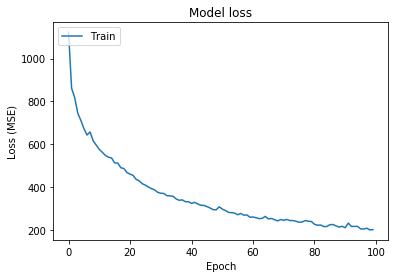

In [8]:
# Plot training & validation accuracy values
# plt.plot(model_history.history['mean_squared_error'])
# plt.title('Model MSE')
# plt.ylabel('MSE')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [7]:
mse = mean_squared_error(test_Y, pred)
rmse_ann = np.sqrt(mse)
print(rmse_ann)

W1014 09:09:54.454296 139783625897792 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1014 09:09:54.482784 139783625897792 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1014 09:09:54.886834 139783625897792 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1014 09:09:54.887365 139783625897792 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W10

16.149555336658747


In [10]:
print(min(pred))
print(max(pred))

[0.6462879]
[596.6783]


Text(0.5, 1.0, 'Residuals')

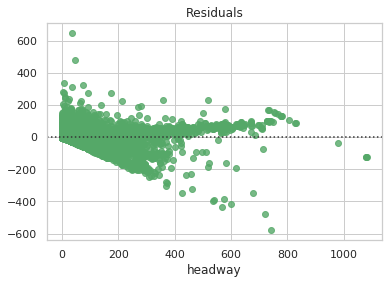

In [22]:
sns.set(style="whitegrid")

# Plot the residuals after fitting a linear model
sns.residplot(test_Y, pred, color="g").set_title('Residuals')

Residuals should not have a standard.

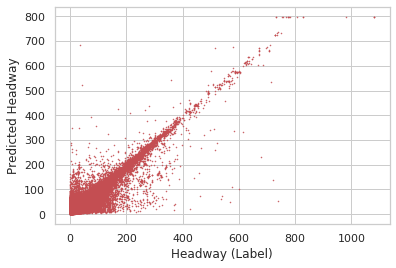

In [23]:
# Print all error to see if there is standard or some big outliers
plt.figure()
plt.plot(test_Y, pred, 'ro', ms=0.5)
plt.xlabel('Headway (Label)')
plt.ylabel('Predicted Headway')
plt.show()

NameError: name 'width' is not defined

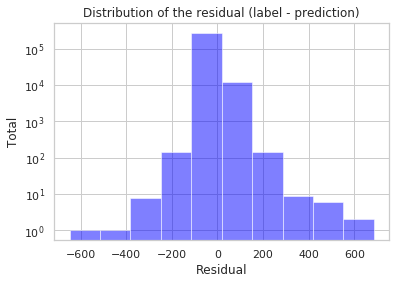

In [24]:
diff = test_Y - np.array(pred).flatten()
num_bins = 10
plt.hist(diff, num_bins, facecolor='blue', alpha=0.5, log=True)
plt.xlabel('Residual')
plt.ylabel('Total')
plt.title('Distribution of the residual (label - prediction)')
plt.rcParams["figure.figsize"] = (width,height) 
plt.show()

In [ ]:
model_history.history